# Policing Disparities Plots - Error Bars from Bootstrapping
This notebook contains code to generate the plots in our paper, using data from a bootstrapping process. 

In [22]:
from pprint import pprint
from pathlib import Path
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
from glob import glob 
import json
import numpy as np
from textwrap import wrap


### LaTeX font rendering (optional, requires local LaTeX installation)

In [2]:
# Requires local LaTeX installation 
rc('font', **{'family': 'serif', 'serif': ['Computer Modern Roman']})
matplotlib.rcParams['text.usetex'] = True
rc('text.latex', preamble=r'\usepackage{amsmath} \usepackage[T1]{fontenc}')

## Directory verification / setup
This code should work by default, assuming the directory layout in the Git repo is unchanged. 

In [3]:
N_BOOTSTRAPS = 100
BOOTSTRAPS_PATH = "../plot_data"
PLOTS_PATH = "../plots/figures"

In [4]:
p = Path(PLOTS_PATH)
if not p.is_dir():
    print("plots directory is empty, creating now...")
    p.mkdir()    

In [5]:
pprint(glob(f"{BOOTSTRAPS_PATH}/*.json"))

['../plot_data/boro_bootstraps.json',
 '../plot_data/density_cbg_bootstraps.json',
 '../plot_data/density_cbg_residential_only_bootstraps.json',
 '../plot_data/median_household_income_bootstraps.json',
 '../plot_data/median_household_income_residential_only_bootstraps.json',
 '../plot_data/neighborhood_bootstraps.json',
 '../plot_data/race_bootstraps.json',
 '../plot_data/race_residential_zones_only_bootstraps.json',
 '../plot_data/zone_bootstraps.json']


In [60]:
def bootstrapped_plots(label_mapping, data_path, ylim, xlabel, xtick_order=None, firstn_filter=-1, lastn_filter=-1, figsize=(5,4)):
    data = json.load(open(data_path))
    print("point estimate")
    for k in data['point_estimate'].keys():
        if k not in label_mapping.keys():
            continue
        print('%-20s %2.3f+/-%2.3f' % (label_mapping[k], 
                                       data['point_estimate'][k], 
                                       np.std([bootstrap_iterate[k] for bootstrap_iterate in data['bootstrap_statistics']]) * 1.96))

    point_estimate = pd.DataFrame.from_dict(data['point_estimate'], orient='index').rename(columns={0:'point_estimate'})
    point_estimate['errorbar'] = point_estimate.index.map(
        lambda x:np.std([bootstrap_iterate[x] for bootstrap_iterate in data['bootstrap_statistics']]) * 1.96)

    point_estimate = point_estimate[point_estimate.index.map(lambda x: x in label_mapping.keys())]
    point_estimate = point_estimate.sort_values(by='point_estimate')[::-1]
    print(point_estimate)
    if len(label_mapping) > 0:
        point_estimate.index = point_estimate.index.map(label_mapping)
        point_estimate.index = point_estimate.index.fillna('ERROR')
    if xtick_order is not None:
        point_estimate = point_estimate.loc[xtick_order]
    # 20 -> old number of bootstraps, mhi rzones only was not rerun 
    assert len(data['bootstrap_statistics']) == N_BOOTSTRAPS or len(data['bootstrap_statistics']) == 20
    
    if (firstn_filter > -1) & (lastn_filter > -1):
        point_estimate = pd.concat([point_estimate.iloc[:firstn_filter], point_estimate.iloc[-lastn_filter:]])
        #std_errs = pd.concat([std_errs.iloc[:firstn_filter] , std_errs.iloc[-lastn_filter:]])
    elif firstn_filter > -1: 
        point_estimate = point_estimate[:firstn_filter]
    elif lastn_filter > -1: 
        point_estimate = point_estimate[-lastn_filter:]

    fig, ax = plt.subplots(figsize=figsize)
    colors_array = point_estimate['point_estimate'].apply(lambda x: '#e14b31' if x > 1 else '#1984c5')
    ax.set_xlim(-0.5,len(point_estimate)-0.5)
    
    xlabels = [ '\n'.join(wrap(l, 12)) for l in point_estimate.index]
    ax.set_xticks(range(len(xlabels)))
    ax.set_xticklabels(xlabels)
    
    
    ax.vlines(x=point_estimate.index, ymax=point_estimate['point_estimate'], ymin=1, linewidth=40, colors=colors_array)
    ax.set_ylabel('Police deployment\n(relative to city average)', fontsize=14)
    ax.errorbar(y=point_estimate['point_estimate'], x=point_estimate.index, yerr=point_estimate['errorbar'], ls='None', capsize=5, capthick=0.5, elinewidth=1, ecolor='black')
    ax.axhline(1, color='black', linewidth=0.8, linestyle='--', alpha=0.7)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylim(ylim)
    yticks = sorted(ylim + [1])
    ax.set_yticks(yticks)
    ax.yaxis.set_major_formatter(matplotlib.ticker.FormatStrFormatter('%0.2fx'))
    
    #for tick in ax.xaxis.get_major_ticks()[1::2]:
    #    tick.set_pad(12)
    plt.tight_layout()
    return fig, ax

## Disparities by race plot code 

In [31]:
RACE_DATA_PATH = f"{BOOTSTRAPS_PATH}/race_bootstraps.json"

In [32]:
race_data_mapping = {
    'Estimate_Total_Not_Hispanic_or_Latino_White_alone_relative_to_average': 'White',
    'Estimate_Total_Not_Hispanic_or_Latino_Black_or_African_American_alone_relative_to_average': 'Black',
    'Estimate_Total_Hispanic_or_Latino_relative_to_average': 'Hispanic',
    'Estimate_Total_Not_Hispanic_or_Latino_Asian_alone_relative_to_average': 'Asian'
}

point estimate
White                0.989+/-0.005
Black                1.040+/-0.006
Hispanic             1.049+/-0.005
Asian                0.879+/-0.006
                                                    point_estimate  errorbar
Estimate_Total_Hispanic_or_Latino_relative_to_a...        1.049442  0.005065
Estimate_Total_Not_Hispanic_or_Latino_Black_or_...        1.040498  0.006059
Estimate_Total_Not_Hispanic_or_Latino_White_alo...        0.989305  0.005256
Estimate_Total_Not_Hispanic_or_Latino_Asian_alo...        0.879257  0.006179


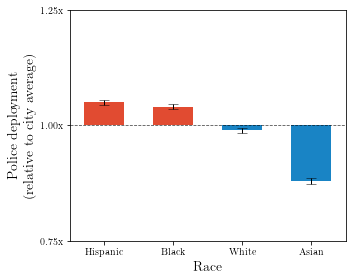

In [33]:
fig, ax = bootstrapped_plots(label_mapping=race_data_mapping, data_path=RACE_DATA_PATH, ylim=[0.75, 1.25], 
                             xlabel='Race')
plt.savefig(f'{PLOTS_PATH}/bootstrapped_race_plot.pdf', bbox_inches="tight")

## Disparities by race (only residential zones) plot code 

In [34]:
RACE_RZONE_DATA_PATH = f"{BOOTSTRAPS_PATH}/race_residential_zones_only_bootstraps.json"

point estimate
White                0.953+/-0.006
Black                1.084+/-0.007
Hispanic             1.082+/-0.006
Asian                0.812+/-0.007
                                                    point_estimate  errorbar
Estimate_Total_Not_Hispanic_or_Latino_Black_or_...        1.083686  0.007101
Estimate_Total_Hispanic_or_Latino_relative_to_a...        1.082149  0.005814
Estimate_Total_Not_Hispanic_or_Latino_White_alo...        0.953283  0.005857
Estimate_Total_Not_Hispanic_or_Latino_Asian_alo...        0.812445  0.007485


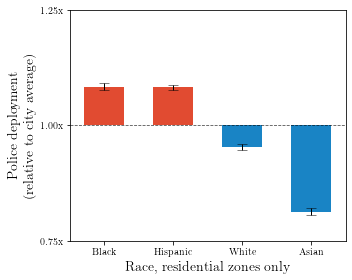

In [35]:
fig, ax = bootstrapped_plots(data_path=RACE_RZONE_DATA_PATH, label_mapping=race_data_mapping, ylim=[0.75, 1.25], 
                             xlabel='Race, residential zones only')
plt.savefig(f'{PLOTS_PATH}/bootstrapped_race_rzones_plot.pdf', bbox_inches="tight")

## Disparities by zone plot code

In [36]:
ZONE_DATA_PATH = f"{BOOTSTRAPS_PATH}/zone_bootstraps.json"

In [37]:
zone_label_mapping = {
    "C_relative_to_average": "Commercial",
    "M_relative_to_average": "Manufacturing",
    "R_relative_to_average": "Residential"
}

point estimate
Commercial           1.979+/-0.025
Manufacturing        0.948+/-0.024
Residential          0.938+/-0.002
                       point_estimate  errorbar
C_relative_to_average        1.979094  0.024676
M_relative_to_average        0.948196  0.024320
R_relative_to_average        0.938197  0.001794


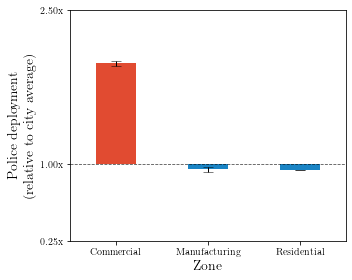

In [38]:
fig, ax = bootstrapped_plots(data_path=ZONE_DATA_PATH, label_mapping=zone_label_mapping, ylim=[0.25, 2.5], 
                             xlabel='Zone')
plt.savefig(f'{PLOTS_PATH}/bootstrapped_zone_plot.pdf', bbox_inches="tight")

## Disparities by income plot code 

In [39]:
INCOME_DATA_PATH = f"{BOOTSTRAPS_PATH}/median_household_income_bootstraps.json"

In [40]:
income_label_mapping = { 
    "median_household_income_quartile_1_relative_to_average": "Lowest",    
    "median_household_income_quartile_2_relative_to_average": "2nd lowest",   
    "median_household_income_quartile_3_relative_to_average": "2nd highest",    
    "median_household_income_quartile_4_relative_to_average": "Highest"
}

point estimate
Lowest               1.122+/-0.010
2nd lowest           0.889+/-0.009
2nd highest          0.898+/-0.010
Highest              1.156+/-0.012
                                                    point_estimate  errorbar
median_household_income_quartile_4_relative_to_...        1.155749  0.011610
median_household_income_quartile_1_relative_to_...        1.121885  0.009963
median_household_income_quartile_3_relative_to_...        0.898250  0.009846
median_household_income_quartile_2_relative_to_...        0.889279  0.008810


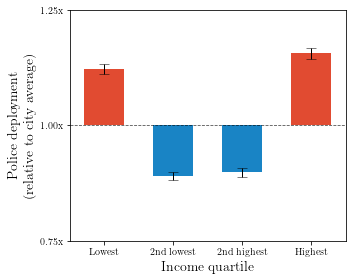

In [41]:
fig, ax = bootstrapped_plots(data_path=INCOME_DATA_PATH, label_mapping=income_label_mapping, ylim=[0.75, 1.25], 
            xlabel='Income quartile', 
            xtick_order=['Lowest', '2nd lowest', '2nd highest', 'Highest'])
plt.savefig(f'{PLOTS_PATH}/bootstrapped_income_plot.pdf', bbox_inches="tight")

## Disparities by income (only residential zones) plot code

In [42]:
INCOME_RZONES_DATA_PATH = f"{BOOTSTRAPS_PATH}/median_household_income_residential_only_bootstraps.json"

point estimate
Lowest               1.194+/-0.010
2nd lowest           0.950+/-0.013
2nd highest          0.922+/-0.009
Highest              0.909+/-0.010
                                                    point_estimate  errorbar
median_household_income_quartile_1_relative_to_...        1.194225  0.009934
median_household_income_quartile_2_relative_to_...        0.950291  0.012735
median_household_income_quartile_3_relative_to_...        0.921574  0.009046
median_household_income_quartile_4_relative_to_...        0.909025  0.009698


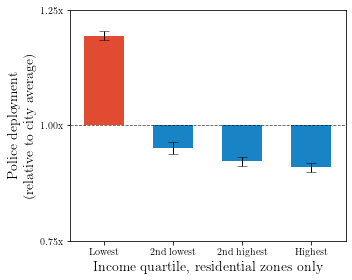

In [43]:
fig, ax = bootstrapped_plots(data_path=INCOME_RZONES_DATA_PATH, label_mapping=income_label_mapping, ylim=[0.75, 1.25], 
                            xlabel='Income quartile, residential zones only', 
                             xtick_order=['Lowest', '2nd lowest', '2nd highest', 'Highest'])
plt.savefig(f'{PLOTS_PATH}/bootstrapped_income_rzones_plot.pdf', bbox_inches="tight")

## Disparities by NYC borough plot code

In [44]:
BOROUGH_DATA_PATH = f"{BOOTSTRAPS_PATH}/boro_bootstraps.json"

In [45]:
borough_label_mapping = {
    "Bronx_relative_to_average":            'The\nBronx',
    "Brooklyn_relative_to_average":         'Brooklyn',
    "Manhattan_relative_to_average":        'Manhattan',
    "Queens_relative_to_average":           'Queens',
    "Staten Island_relative_to_average":    'Staten Island'
}

point estimate
The
Bronx            0.994+/-0.013
Brooklyn             0.933+/-0.007
Manhattan            1.616+/-0.011
Queens               0.739+/-0.008
Staten Island        0.510+/-0.024
                                   point_estimate  errorbar
Manhattan_relative_to_average            1.615770  0.011079
Bronx_relative_to_average                0.994465  0.013500
Brooklyn_relative_to_average             0.932757  0.007128
Queens_relative_to_average               0.739373  0.008279
Staten Island_relative_to_average        0.509756  0.024455


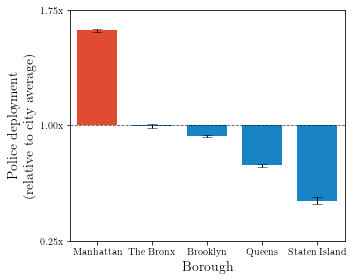

In [46]:
fig, ax = bootstrapped_plots(data_path=BOROUGH_DATA_PATH, label_mapping=borough_label_mapping, ylim=[0.25, 1.75], 
                             xlabel='Borough')
plt.savefig(f'{PLOTS_PATH}/bootstrapped_borough_plot.pdf', bbox_inches="tight")

## Disparities by density quartile plot code

In [47]:
DENSITY_DATA_PATH = f"{BOOTSTRAPS_PATH}/density_cbg_bootstraps.json"

In [48]:
density_label_mapping = { 
    "density_cbg_quartile_1_relative_to_average":    "Lowest",
    "density_cbg_quartile_2_relative_to_average":    "2nd lowest",
    "density_cbg_quartile_3_relative_to_average":    "2nd highest",
    "density_cbg_quartile_4_relative_to_average":    "Highest"
}

point estimate
Lowest               0.647+/-0.014
2nd lowest           0.786+/-0.008
2nd highest          1.043+/-0.007
Highest              1.214+/-0.007
                                            point_estimate  errorbar
density_cbg_quartile_4_relative_to_average        1.214186  0.006972
density_cbg_quartile_3_relative_to_average        1.042544  0.007345
density_cbg_quartile_2_relative_to_average        0.785693  0.007809
density_cbg_quartile_1_relative_to_average        0.647196  0.014485


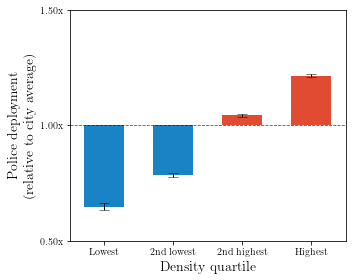

In [49]:
fig, ax = bootstrapped_plots(data_path=DENSITY_DATA_PATH, label_mapping=density_label_mapping, ylim=[0.5, 1.5], 
                             xlabel='Density quartile', 
                             xtick_order=['Lowest', '2nd lowest', '2nd highest', 'Highest'])
plt.savefig(f'{PLOTS_PATH}/bootstrapped_density_plot.pdf', bbox_inches="tight")

## Disparities by density quartile (only residential zones) plot code

In [50]:
DENSITY_RZONES_DATA_PATH = f"{BOOTSTRAPS_PATH}/density_cbg_residential_only_bootstraps.json"

point estimate
Lowest               0.624+/-0.011
2nd lowest           0.872+/-0.011
2nd highest          1.054+/-0.009
Highest              1.238+/-0.010
                                            point_estimate  errorbar
density_cbg_quartile_4_relative_to_average        1.237624  0.009738
density_cbg_quartile_3_relative_to_average        1.053739  0.009376
density_cbg_quartile_2_relative_to_average        0.871690  0.010686
density_cbg_quartile_1_relative_to_average        0.623835  0.010814


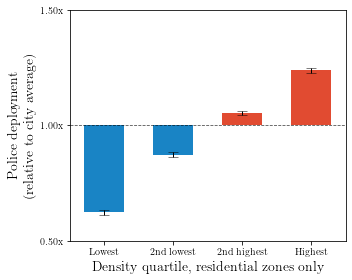

In [51]:
fig, ax = bootstrapped_plots(data_path=DENSITY_RZONES_DATA_PATH, label_mapping=density_label_mapping, ylim=[0.5, 1.5], 
                             xlabel='Density quartile, residential zones only', 
                            xtick_order=['Lowest', '2nd lowest', '2nd highest', 'Highest'])
plt.savefig(f'{PLOTS_PATH}/bootstrapped_density_rzones_plot.pdf', bbox_inches="tight")

## Disparities by neighborhood tabulation area (NTA) plot code

In [52]:
NTA_DATA_PATH = f"{BOOTSTRAPS_PATH}/neighborhood_bootstraps.json"

In [53]:
nta_data = json.load(open(NTA_DATA_PATH))
list(nta_data['point_estimate'].keys())
ntas_keys = list(nta_data['point_estimate'].keys())
ntas_keys = [x for x in ntas_keys if 'relative_to_average' in x]
ntas = [x.replace('_relative_to_average', '') for x in ntas_keys]
nta_label_mapping = dict(zip(ntas_keys, ntas))


point estimate
                     1.881+/-0.683
Allerton             0.664+/-0.101
Alley Pond Park      0.337+/-0.051
Annadale-Huguenot-Prince's Bay-Woodrow 0.340+/-0.100
Arden Heights-Rossville 0.225+/-0.016
Astoria (Central)    1.042+/-0.064
Astoria (East)-Woodside (North) 0.558+/-0.039
Astoria (North)-Ditmars-Steinway 0.572+/-0.046
Auburndale           0.356+/-0.048
Baisley Park         0.998+/-0.074
Barren Island-Floyd Bennett Field 0.391+/-0.063
Bath Beach           0.958+/-0.072
Bay Ridge            0.610+/-0.036
Bay Terrace-Clearview 0.308+/-0.053
Bayside              0.776+/-0.075
Bedford Park         0.732+/-0.053
Bedford-Stuyvesant (East) 1.183+/-0.045
Bedford-Stuyvesant (West) 1.350+/-0.053
Bellerose            0.375+/-0.044
Belmont              1.020+/-0.084
Bensonhurst          0.507+/-0.033
Borough Park         0.711+/-0.033
Breezy Point-Belle Harbor-Rockaway Park-Broad Channel 0.878+/-0.234
Brighton Beach       0.790+/-0.091
Bronx Park           0.513+/-0.042
Brooklyn 

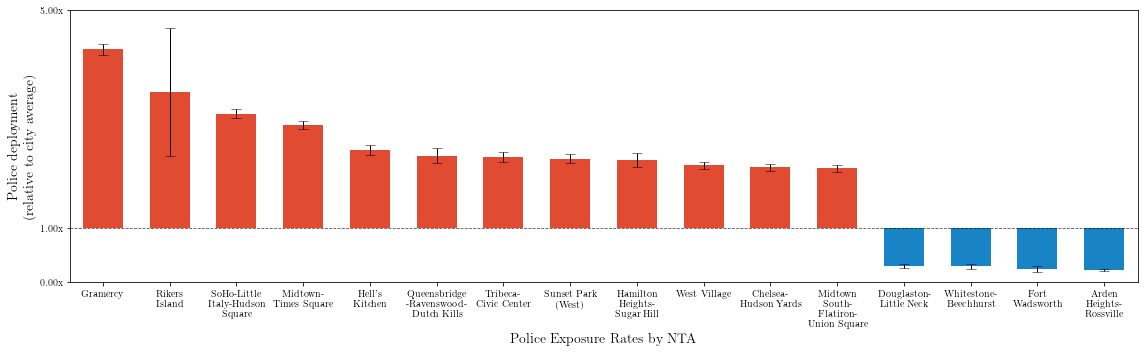

In [64]:
# Top 12 Neighborhoods
fig, ax = bootstrapped_plots(data_path=NTA_DATA_PATH, label_mapping=nta_label_mapping, firstn_filter=12, lastn_filter=4, ylim=[0,5], xlabel='Police Exposure Rates by NTA', figsize=(16,5))
plt.savefig(f'{PLOTS_PATH}/bootstrapped_ntas_plot_t12b4.pdf', bbox_inches="tight")

point estimate
                     1.881+/-0.683
Allerton             0.664+/-0.101
Alley Pond Park      0.337+/-0.051
Annadale-Huguenot-Prince's Bay-Woodrow 0.340+/-0.100
Arden Heights-Rossville 0.225+/-0.016
Astoria (Central)    1.042+/-0.064
Astoria (East)-Woodside (North) 0.558+/-0.039
Astoria (North)-Ditmars-Steinway 0.572+/-0.046
Auburndale           0.356+/-0.048
Baisley Park         0.998+/-0.074
Barren Island-Floyd Bennett Field 0.391+/-0.063
Bath Beach           0.958+/-0.072
Bay Ridge            0.610+/-0.036
Bay Terrace-Clearview 0.308+/-0.053
Bayside              0.776+/-0.075
Bedford Park         0.732+/-0.053
Bedford-Stuyvesant (East) 1.183+/-0.045
Bedford-Stuyvesant (West) 1.350+/-0.053
Bellerose            0.375+/-0.044
Belmont              1.020+/-0.084
Bensonhurst          0.507+/-0.033
Borough Park         0.711+/-0.033
Breezy Point-Belle Harbor-Rockaway Park-Broad Channel 0.878+/-0.234
Brighton Beach       0.790+/-0.091
Bronx Park           0.513+/-0.042
Brooklyn 

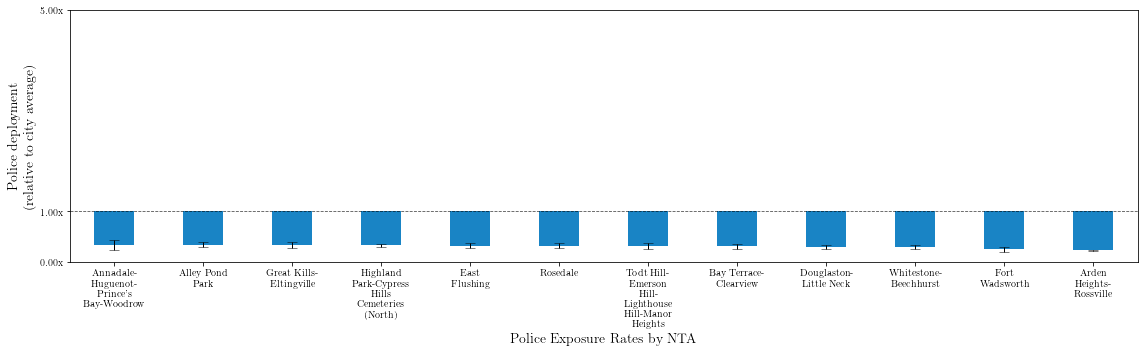

In [65]:
# Bottom 12 Neighborhoods
fig, ax = bootstrapped_plots(data_path=NTA_DATA_PATH, label_mapping=nta_label_mapping, firstn_filter=-1, lastn_filter=12, ylim=[0,5], xlabel='Police Exposure Rates by NTA', figsize=(16,5))
plt.savefig(f'{PLOTS_PATH}/bootstrapped_ntas_plot_bottom12.pdf', bbox_inches="tight")